## DAB 401: Final Group Project

## Predicting cross sell capabilities of insurance sales


In [2]:
import pandas as pd
import numpy as np 
import warnings
warnings.filterwarnings('ignore')
# Import useful libraries

import time
import re
import string
from numpy import mean
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest, f_classif

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, KFold, GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, classification_report 
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.utils.multiclass import type_of_target

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier



import warnings
warnings.filterwarnings('ignore')

In [3]:
# Concatinating Train and Test into one file 
file1 = open("C:/supply_chain/train.csv", "a")
file2 = open("C:/supply_chain/test.csv", "r")

for line in file2:
   file1.write(line)

file1.close()
file2.close()


In [4]:
concatenated_df= pd.read_csv("C:/supply_chain/train.csv")

In [5]:
concatenated_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28,0,> 2 Years,Yes,40454,26,217,1.0
1,2,Male,76,1,3,0,1-2 Year,No,33536,26,183,0.0
2,3,Male,47,1,28,0,> 2 Years,Yes,38294,26,27,1.0
3,4,Male,21,1,11,1,< 1 Year,No,28619,152,203,0.0
4,5,Female,29,1,41,1,< 1 Year,No,27496,152,39,0.0


In [6]:
# finding the shape of the dataset 
print('shape of the dataset',concatenated_df.shape)

shape of the dataset (1016256, 12)


In [7]:
# checking for the null values 
concatenated_df.isnull().sum()

id                           0
Gender                       0
Age                          0
Driving_License              0
Region_Code                  0
Previously_Insured           0
Vehicle_Age                  0
Vehicle_Damage               0
Annual_Premium               0
Policy_Sales_Channel         0
Vintage                      0
Response                635147
dtype: int64

In [8]:
#converting to numeric type
concatenated_df['Vintage']=pd.to_numeric(concatenated_df['Vintage'],errors='coerce')
concatenated_df['Annual_Premium']=pd.to_numeric(concatenated_df['Annual_Premium'],errors='coerce')
concatenated_df['Age']=pd.to_numeric(concatenated_df['Age'],errors='coerce')
concatenated_df['id']=pd.to_numeric(concatenated_df['id'],errors='coerce')


   ## Exploratory Data Analysis

In [9]:
concatenated_df.nunique()

id                      508146
Gender                       3
Age                         66
Driving_License              5
Region_Code                107
Previously_Insured           5
Vehicle_Age                  4
Vehicle_Damage               3
Annual_Premium           52062
Policy_Sales_Channel       302
Vintage                    290
Response                     2
dtype: int64

(array([18., 19., 15.,  7.,  1.,  1.,  1.,  0.,  2.,  2.]),
 array([1.60000e+01, 6.91270e+03, 1.38094e+04, 2.07061e+04, 2.76028e+04,
        3.44995e+04, 4.13962e+04, 4.82929e+04, 5.51896e+04, 6.20863e+04,
        6.89830e+04]),
 <BarContainer object of 10 artists>)

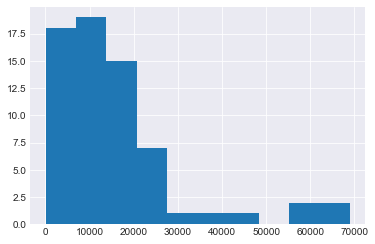

In [10]:
plt.hist(concatenated_df['Age'].value_counts().head(66), bins = 10)

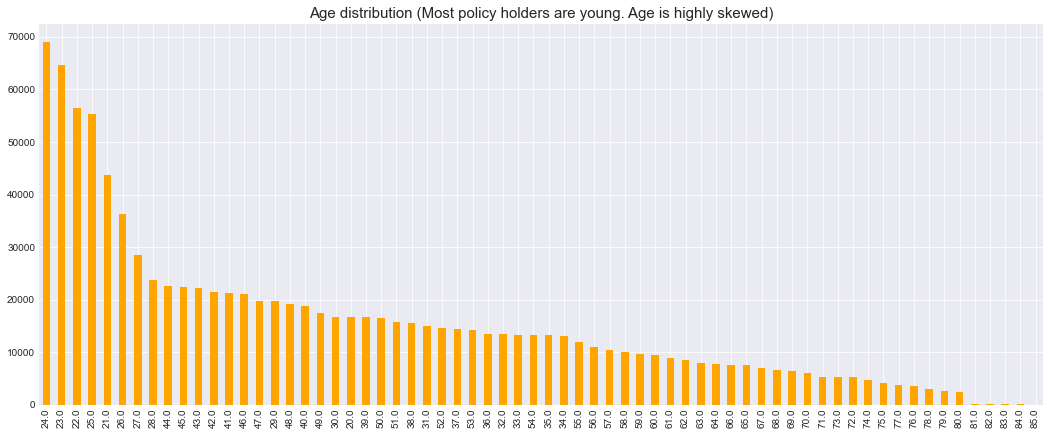

In [11]:
# looking at the frequency of records by age

plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.copper(np.linspace(0, 1, 66))
concatenated_df['Age'].value_counts().head(66).plot.bar(color = 'orange')
plt.title('Age distribution (Most policy holders are young. Age is highly skewed)', fontsize = 15)
plt.xticks(rotation = 90)
plt.show()

In [12]:
print (concatenated_df.dtypes)

id                      float64
Gender                   object
Age                     float64
Driving_License          object
Region_Code              object
Previously_Insured       object
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel     object
Vintage                 float64
Response                float64
dtype: object


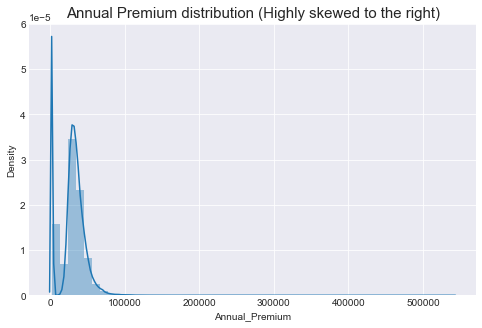

In [13]:
plt.figure(figsize = (8, 5))
sns.distplot(concatenated_df['Annual_Premium'])
plt.title('Annual Premium distribution (Highly skewed to the right)', fontsize = 15)
plt.show()

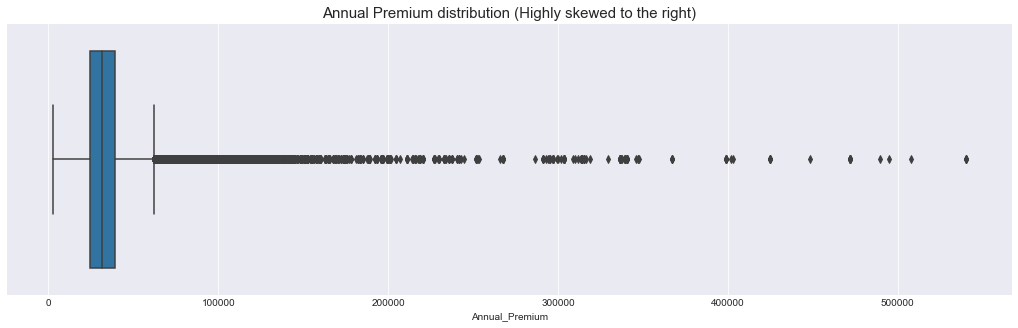

In [14]:
plt.figure(figsize = (18, 5))
sns.boxplot(concatenated_df['Annual_Premium'])
plt.title('Annual Premium distribution (Highly skewed to the right)', fontsize = 15)
plt.show()

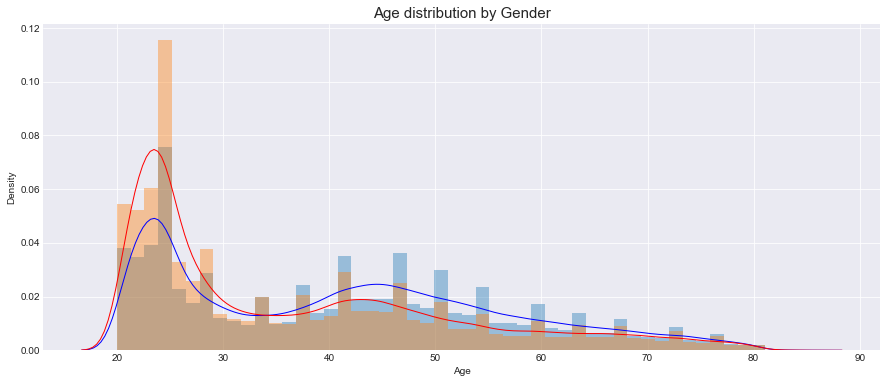

In [15]:
plt.figure(figsize = (15, 6))
sns.distplot(concatenated_df.loc[(concatenated_df['Gender'] == 'Male'), 'Age'], kde_kws = {"color": "b", "lw": 1, "label": "Male"})
sns.distplot(concatenated_df.loc[(concatenated_df['Gender'] == 'Female'), 'Age'], kde_kws = {"color": "r", "lw": 1, "label": "Female"})
plt.title('Age distribution by Gender', fontsize = 15)
plt.show()

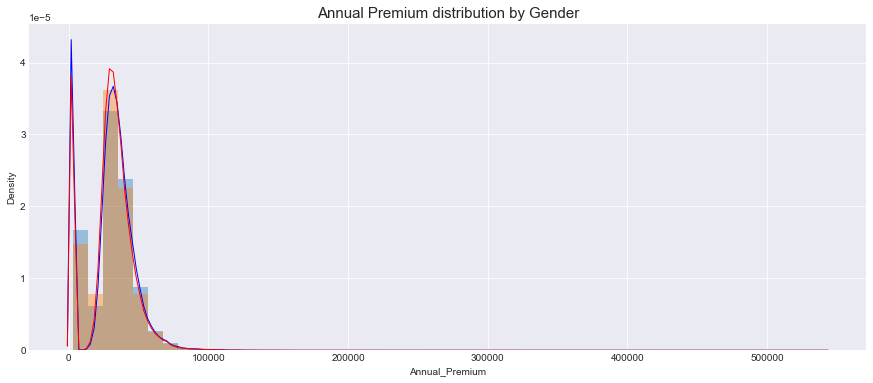

In [16]:
plt.figure(figsize = (15, 6))
sns.distplot(concatenated_df.loc[(concatenated_df['Gender'] == 'Male'), 'Annual_Premium'], kde_kws = {"color": "b", "lw": 1, "label": "Male"})
sns.distplot(concatenated_df.loc[(concatenated_df['Gender'] == 'Female'), 'Annual_Premium'], kde_kws = {"color": "r", "lw": 1, "label": "Female"})
plt.title('Annual Premium distribution by Gender', fontsize = 15)
plt.show()

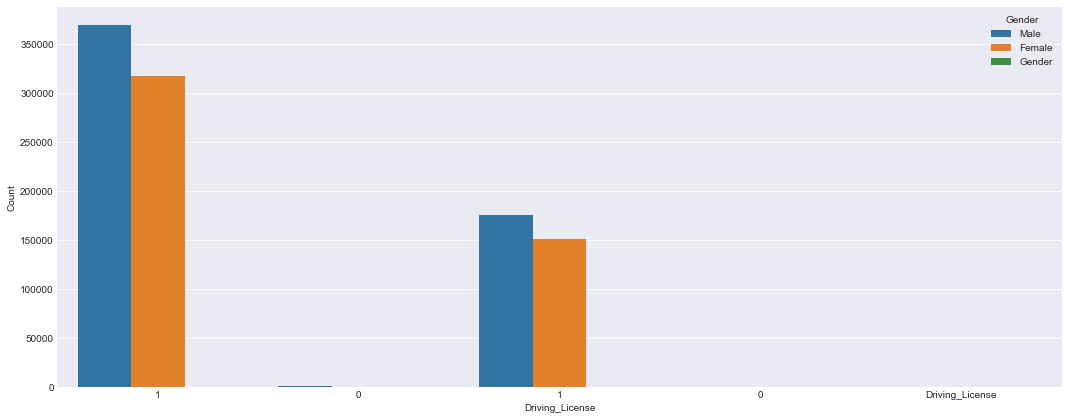

In [17]:
sns.countplot(data = concatenated_df, x ='Driving_License' , hue = 'Gender')
plt.ylabel('Count')
plt.show()

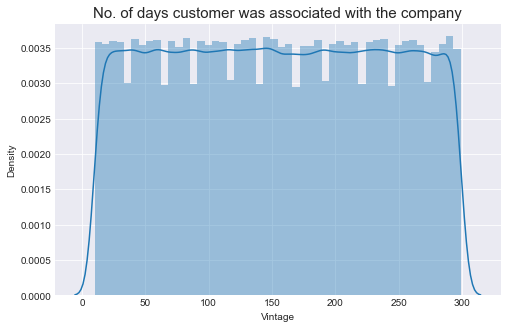

In [18]:
plt.figure(figsize = (8, 5))
sns.distplot(concatenated_df['Vintage'])
plt.title('No. of days customer was associated with the company', fontsize = 15)
plt.show()

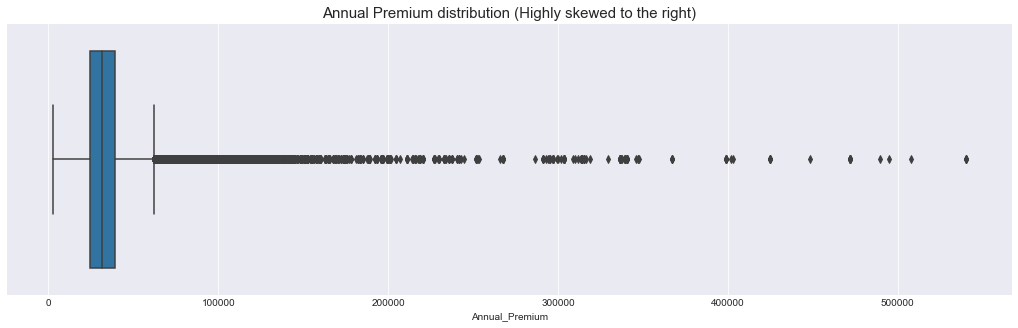

In [19]:
plt.figure(figsize = (18, 5))
sns.boxplot(concatenated_df['Annual_Premium'])
plt.title('Annual Premium distribution (Highly skewed to the right)', fontsize = 15)
plt.show()

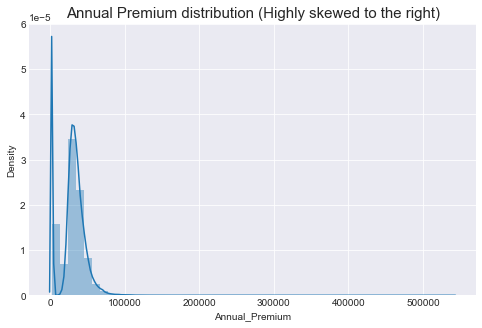

In [20]:
plt.figure(figsize = (8, 5))
sns.distplot(concatenated_df['Annual_Premium'])
plt.title('Annual Premium distribution (Highly skewed to the right)', fontsize = 15)
plt.show()